In [2]:
from Bio import SeqIO
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

def string_to_array(seq_string):
   seq_string = seq_string.lower()
   seq_string = re.sub('[^acgt]', 'n', seq_string)
   seq_string = np.array(list(seq_string))
   return seq_string

# create a label encoder with 'acgtn' alphabet
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, lets say n
    return float_encoded

def one_hot_encoder(seq_string):
    int_encoded = label_encoder.transform(seq_string)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    int_encoded = int_encoded.reshape(len(int_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

def Kmers_funct(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

def readdata(location, title):
    dna = pd.read_table(location)
    dna['class'].value_counts().sort_index().plot.bar()
    plt.title(title)
    return dna

def convertkmerstoword(input):
    listofwords = list(input)
    for item in range(len(listofwords)):
        listofwords[item] = ' '.join(listofwords[item])
    return listofwords

def reformatfeatures(features):
    cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
    X = cv.fit_transform(features)
    return X, cv
    
def buildmodel(X_train, y_train):
    classifier = MultinomialNB(alpha=0.1)
    classifier.fit(X_train, y_train)
    return classifier
    
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

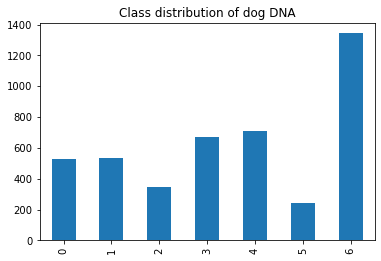

In [4]:
human_dna = readdata('../input/dna-sequence-dataset/human.txt', "Class distribution of Human DNA")
chimp_dna = readdata('../input/dna-sequence-dataset/chimpanzee.txt', "Class distribution of chimpanzee DNA")
dog_dna = readdata('../input/dna-sequence-dataset/dog.txt', "Class distribution of dog DNA")

human_dna['words'] = human_dna.apply(lambda x: Kmers_funct(x['sequence'], 6), axis=1)
human_dna = human_dna.drop('sequence', axis=1)

chimp_dna['words'] = chimp_dna.apply(lambda x: Kmers_funct(x['sequence'], 6), axis=1)
chimp_dna = chimp_dna.drop('sequence', axis=1)

dog_dna['words'] = dog_dna.apply(lambda x: Kmers_funct(x['sequence'], 6), axis=1)
dog_dna = dog_dna.drop('sequence', axis=1)

human_texts = convertkmerstoword(human_dna['words'])
y_human = human_dna.iloc[:, 0].values # y_human for human_dna

chimp_texts = convertkmerstoword(chimp_dna['words'])
y_chim = chimp_dna.iloc[:, 0].values # y_chim for chimp_dna

dog_texts = convertkmerstoword(dog_dna['words'])
y_dog = dog_dna.iloc[:, 0].values  # y_dog for dog_dna


In [6]:
X_human, human_cv = reformatfeatures(human_texts)
X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_human, 
                                                    y_human, 
                                                    test_size = 0.20, 
                                                    random_state=42)
hsclassifier = buildmodel(X_h_train, y_h_train)
y_h_pred = hsclassifier.predict(X_h_test)
accuracy, precision, recall, f1 = get_metrics(y_h_test, y_h_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

results = pd.DataFrame({"TrainOrg": ["Human"],
                        "TestOrg": ["Human"],
                        "accuracy": [accuracy],
                        "precision": [precision],
                        "nrecall": [recall],
                        "f1": [f1]})

accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


In [10]:
X_chimp, chimp_cv = reformatfeatures(chimp_texts)
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_chimp, 
                                                    y_chim, 
                                                    test_size = 0.20, 
                                                    random_state=42)
chimclassifier = buildmodel(X_c_train, y_c_train)
y_c_pred = chimclassifier.predict(X_c_test)
accuracy, precision, recall, f1 = get_metrics(y_c_test, y_c_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

results = results.append({"TrainOrg": "Chimp",
                        "TestOrg": "Chimp",
                        "accuracy": accuracy,
                        "precision": precision,
                        "nrecall": recall,
                        "f1": f1}, ignore_index=True)


accuracy = 0.914 
precision = 0.920 
recall = 0.914 
f1 = 0.911


,TrainOrg,TestOrg,accuracy,precision,nrecall,f1
0,Human,Human,0.984018,0.984291,0.984018,0.984027
1,[Chimp],[Chimp],[0.913946587537092],[0.9197801649173679],[0.913946587537092],[0.9109242726006946]
2,Chimp,Chimp,0.913947,0.91978,0.913947,0.910924


In [11]:
X_dog, dog_cv = reformatfeatures(dog_texts)
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_dog, 
                                                    y_dog, 
                                                    test_size = 0.20, 
                                                    random_state=42)
dogclassifier = buildmodel(X_d_train, y_d_train)
y_d_pred = dogclassifier.predict(X_d_test)
accuracy, precision, recall, f1 = get_metrics(y_d_test, y_d_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

results = results.append({"TrainOrg": "Dog",
                        "TestOrg": "Dog",
                        "accuracy": accuracy,
                        "precision": precision,
                        "nrecall": recall,
                        "f1": f1}, ignore_index=True)


accuracy = 0.695 
precision = 0.785 
recall = 0.695 
f1 = 0.678


In [51]:
y_pred_hsclass_chimp = hsclassifier.predict(human_cv.transform(chimp_texts))
accuracy, precision, recall, f1 = get_metrics(y_chim, y_pred_hsclass_chimp)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

y_pred_hsclass_dog = hsclassifier.predict(human_cv.transform(dog_texts))
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_hsclass_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993
accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925


In [54]:
y_pred_chimclass_human = chimclassifier.predict(chimp_cv.transform(human_texts))
y_pred_chimclass_dog = chimclassifier.predict(chimp_cv.transform(dog_texts))

accuracy, precision, recall, f1 = get_metrics(y_human, y_pred_chimclass_human)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_chimclass_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.931 
precision = 0.937 
recall = 0.931 
f1 = 0.931
accuracy = 0.909 
precision = 0.922 
recall = 0.909 
f1 = 0.909


In [55]:
y_pred_dogclass_human = dogclassifier.predict(dog_cv.transform(human_texts))
y_pred_dogclass_chimp = dogclassifier.predict(dog_cv.transform(chimp_texts))

accuracy, precision, recall, f1 = get_metrics(y_human, y_pred_dogclass_human)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy, precision, recall, f1 = get_metrics(y_chim, y_pred_dogclass_chimp)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.795 
precision = 0.820 
recall = 0.795 
f1 = 0.794
accuracy = 0.861 
precision = 0.881 
recall = 0.861 
f1 = 0.860
